### Import external modules

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

### Add mbt-gym to path

In [2]:
import sys
sys.path.append("../")

In [3]:
from mbt_gym.agents.BaselineAgents import CarteaJaimungalMmAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import CjCriterion, CjMmCriterion
from mbt_gym.stochastic_processes.midprice_models import *
from mbt_gym.stochastic_processes.fill_probability_models import *
from mbt_gym.stochastic_processes.arrival_models import *

### Add parameters for limit order market making environment

In [4]:
terminal_time = 1.0
arrival_rate = 10.0
n_steps = int(10 * terminal_time * arrival_rate)
phi = 0.5
alpha = 0.001

In [5]:
def get_cj_env_Poisson(num_trajectories:int = 1):    
    fill_exponent = 1
    sigma = 0.1
    initial_inventory = (-4,5)
    initial_price = 100
    step_size = terminal_time/n_steps
    max_depth = 5
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    midprice_model = BrownianMotionMidpriceModel(volatility=sigma, 
                                                                   terminal_time=terminal_time, 
                                                                   step_size=step_size, 
                                                                   initial_price=initial_price, 
                                                                   num_trajectories=num_trajectories)
    arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate, arrival_rate]), step_size=step_size)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                                       step_size=step_size, 
                                                                       num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories, max_depth = max_depth)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      reward_function = CjMmCriterion(phi, alpha),
                      max_inventory=n_steps,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [6]:
def get_cj_env_Hawkes(num_trajectories:int = 1):    
    fill_exponent = 1
    sigma = 0.1
    initial_inventory = (-4,5)
    initial_price = 100
    max_depth = 5
    step_size = terminal_time/n_steps
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    midprice_model = BrownianMotionMidpriceModel(volatility=sigma, 
                                                                   terminal_time=terminal_time, 
                                                                   step_size=step_size, 
                                                                   initial_price=initial_price, 
                                                                   num_trajectories=num_trajectories)
    arrival_model = HawkesArrivalModel(num_trajectories=num_trajectories, step_size=step_size)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                                       step_size=step_size, 
                                                                       num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories, max_depth = max_depth)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      reward_function = CjMmCriterion(phi, alpha),
                      max_inventory=n_steps,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [7]:
num_trajectories = 1000
env = ReduceStateSizeWrapper(get_cj_env_Hawkes(num_trajectories), [1,2,4,5])
sb_env = StableBaselinesTradingEnvironment(trading_env=env)

In [8]:
cj_agent = CarteaJaimungalMmAgent(env=get_cj_env_Poisson(num_trajectories), max_inventory = 10)

In [9]:
# Monitor sb_env
sb_env = VecMonitor(sb_env)
# Add directory for tensorboard logging 
tensorboard_logdir = "./tensorboard/PPO-learning-Hawkes/"
best_model_path = "./SB_models/PPO-best-Hawkes"

### Define PPO policy

In [10]:
policy_kwargs = dict(net_arch=[dict(pi=[64, 64], vf=[128, 128])])
PPO_params = {"policy":'MlpPolicy', "env": sb_env, "verbose":1, 
              "policy_kwargs":policy_kwargs, 
              "tensorboard_log":tensorboard_logdir,
              "batch_size": int(n_steps * num_trajectories / 20), 
              "n_steps": int(n_steps)} #256 before (batch size)
callback_params = dict(eval_env=sb_env, n_eval_episodes = 2048, 
                       eval_freq = 200,#200 before  (n_eval_episodes)
                       best_model_save_path = best_model_path, 
                       deterministic=True)

callback = EvalCallback(**callback_params)

In [11]:
model = PPO(**PPO_params, device="cpu")

Using cpu device


In [12]:
model.learn(total_timesteps = 1_000)

Logging to ./tensorboard/PPO-learning-Hawkes/PPO_5
-----------------------------------
| rollout/           |            |
|    ep_len_mean     | 100        |
|    ep_rew_mean     | -1.9913275 |
| time/              |            |
|    fps             | 88501      |
|    iterations      | 1          |
|    time_elapsed    | 1          |
|    total_timesteps | 100000     |
-----------------------------------


## Comparing the learnt policy to the optimal policy

In [13]:
from mbt_gym.agents.SbAgent import SbAgent

In [14]:
agent = SbAgent(model)

In [15]:
inventories = np.arange(-3,4,1)
bid_actions = {}
ask_actions = {}
intensities=[5,10,20]
for intensity in intensities:
    bid_actions[intensity] = []
    ask_actions[intensity] = []
    for inventory in inventories:
        bid_action, ask_action = np.reshape(model.predict([inventory,0.5, intensity, intensity], deterministic=True)[0], 2)    
        bid_actions[intensity].append(bid_action)
        ask_actions[intensity].append(ask_action)

In [16]:
cj_agent.get_action(np.array([[0,inventory,0.5]]))

array([[2.13050023, 0.17718684],
       [2.13050023, 0.17718684],
       [2.13050023, 0.17718684],
       ...,
       [2.13050023, 0.17718684],
       [2.13050023, 0.17718684],
       [2.13050023, 0.17718684]])

In [17]:
# Get the Cartea Jaimungal action
cj_bid_actions = []
cj_ask_actions = []
for inventory in inventories:
    bid_action, ask_action = cj_agent.get_action(np.array([[0,inventory,0.5]]))[0,:].reshape(-1)
    cj_bid_actions.append(bid_action)
    cj_ask_actions.append(ask_action)

In [18]:
bid_actions

{5: [-0.117233664,
  -0.11285846,
  -0.10468802,
  -0.09140444,
  -0.07310583,
  -0.05277792,
  -0.03242073],
 10: [-0.10967854,
  -0.10459479,
  -0.098146826,
  -0.08990748,
  -0.0805542,
  -0.07111423,
  -0.061814878],
 20: [-0.09598047,
  -0.09307672,
  -0.0894174,
  -0.08524875,
  -0.08103861,
  -0.0769711,
  -0.07322182]}

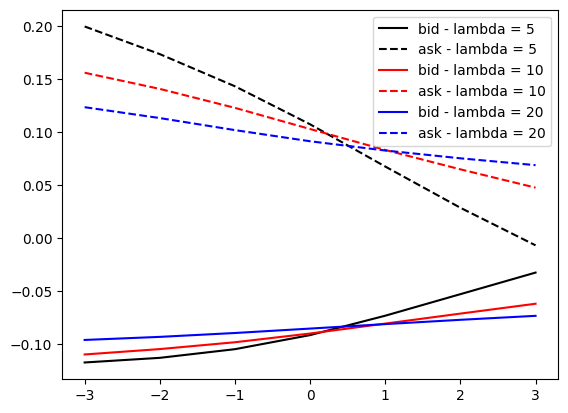

In [19]:
colors = ["k", "r", "b"]

for i, intensity in enumerate(intensities):
    plt.plot(inventories, bid_actions[intensity], label = f"bid - lambda = {intensity}", color = colors[i])
    plt.plot(inventories, ask_actions[intensity], label = f"ask - lambda = {intensity}", color = colors[i], linestyle = "--")
plt.legend()

In [20]:
timestamps = np.arange(0,1 + 0.01, 0.01)

In [21]:
bid_actions = {}
ask_actions = {}
# loop over intensities? (currently just using 10 below)
for inventory in inventories:
    bid_actions[inventory] = []
    ask_actions[inventory] = []
    for timestamp in timestamps:
        state = np.array([[inventory, timestamp, 10, 10]])
        bid_action, ask_action = agent.get_action(state)
        bid_actions[inventory].append(bid_action)
        ask_actions[inventory].append(ask_action)

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
state

In [ ]:
model.predict(state, deterministic=True)

In [ ]:
for inventory in inventories:
    plt.plot(timestamps, bid_actions[inventory], label=f"bid: q = {inventory}")
plt.legend()
plt.show()

In [ ]:
for inventory in inventories:
    plt.plot(timestamps, ask_actions[inventory], label=f"ask: q = {inventory}")
plt.legend()
plt.show()

In [ ]:
model.save("trained_model")

In [ ]:
loaded = PPO.load("trained_model.zip")

In [ ]:
loaded